In [1]:
#!/usr/bin/env python3
import numpy as np
import gym
import os
from pathlib import Path

from stable_baselines.common.cmd_util import mujoco_arg_parser
from stable_baselines import bench, logger
from stable_baselines.common import set_global_seeds
from stable_baselines.common.vec_env.vec_normalize import VecNormalize
from stable_baselines.ppo1 import PPO1
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, CnnPolicy
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import time
from IPython import display
from IPython.display import clear_output
%matplotlib inline

home = str(Path.home())

In [2]:
from collections import deque
import time

import tensorflow as tf
from mpi4py import MPI

from stable_baselines.common import Dataset, explained_variance, fmt_row, zipsame, ActorCriticRLModel, SetVerbosity, \
    TensorboardWriter
import stable_baselines.common.tf_util as tf_util
from stable_baselines.common.policies import LstmPolicy, ActorCriticPolicy
from stable_baselines.common.mpi_adam import MpiAdam
from stable_baselines.common.mpi_moments import mpi_moments
from stable_baselines.trpo_mpi.utils import add_vtarg_and_adv, flatten_lists
from stable_baselines.a2c.utils import total_episode_reward_logger

from stable_baselines.common.vec_env import VecEnv

In [7]:
def traj_segment_generator(policy, env, horizon, reward_giver=None, gail=False):
    """
    Compute target value using TD(lambda) estimator, and advantage with GAE(lambda)
    :param policy: (MLPPolicy) the policy
    :param env: (Gym Environment) the environment
    :param horizon: (int) the number of timesteps to run per batch
    :param reward_giver: (TransitionClassifier) the reward predicter from obsevation and action
    :param gail: (bool) Whether we are using this generator for standard trpo or with gail
    :return: (dict) generator that returns a dict with the following keys:
        - ob: (np.ndarray) observations
        - rew: (numpy float) rewards (if gail is used it is the predicted reward)
        - vpred: (numpy float) action logits
        - new: (numpy bool) dones (is end of episode)
        - ac: (np.ndarray) actions
        - prevac: (np.ndarray) previous actions
        - nextvpred: (numpy float) next action logits
        - ep_rets: (float) cumulated current episode reward
        - ep_lens: (int) the length of the current episode
        - ep_true_rets: (float) the real environment reward
    """
    # Check when using GAIL
    assert not (gail and reward_giver is None), "You must pass a reward giver when using GAIL"

    # Initialize state variables
    step = 0
    action = env.action_space.sample()  # not used, just so we have the datatype
    new = True
    observation = env.reset()

    cur_ep_ret = 0  # return in current episode
    cur_ep_len = 0  # len of current episode
    cur_ep_true_ret = 0
    ep_true_rets = []
    ep_rets = []  # returns of completed episodes in this segment
    ep_lens = []  # Episode lengths

    # Initialize history arrays
    observations = np.array([observation for _ in range(horizon)])
    true_rews = np.zeros(horizon, 'float32')
    rews = np.zeros(horizon, 'float32')
    vpreds = np.zeros(horizon, 'float32')
    dones = np.zeros(horizon, 'int32')
    actions = np.array([action for _ in range(horizon)])
    prev_actions = actions.copy()
    states = policy.initial_state
    done = None

    action_history = []
    prevac = action
    while True:
        action_history.append(action)
        prevprevac = prevac
        prevac = action
        action, vpred, states, _ = policy.step(observation.reshape(-1, *observation.shape), states, done)
        # Slight weirdness here because we need value function at time T
        # before returning segment [0, T-1] so we get the correct
        # terminal value
        if step > 0 and step % horizon == 0:
            # Fix to avoid "mean of empty slice" warning when there is only one episode
            if len(ep_rets) == 0:
                ep_rets = [cur_ep_ret]
                ep_lens = [cur_ep_len]
                ep_true_rets = [cur_ep_true_ret]
                total_timesteps = cur_ep_len
            else:
                total_timesteps = sum(ep_lens) + cur_ep_len

            yield {"ob": observations, "rew": rews, "dones": dones, "true_rew": true_rews, "vpred": vpreds,
                   "ac": actions, "prevac": prev_actions, "nextvpred": vpred * (1 - new), "ep_rets": ep_rets,
                   "ep_lens": ep_lens, "ep_true_rets": ep_true_rets, "total_timestep": total_timesteps}
            _, vpred, _, _ = policy.step(observation.reshape(-1, *observation.shape))
            # Be careful!!! if you change the downstream algorithm to aggregate
            # several of these batches, then be sure to do a deepcopy
            ep_rets = []
            ep_true_rets = []
            ep_lens = []
        i = step % horizon
        observations[i] = observation
        vpreds[i] = vpred[0]
        actions[i] = action[0]
        prev_actions[i] = prevac

        clipped_action = action
        # Clip the actions to avoid out of bound error
        if isinstance(env.action_space, gym.spaces.Box):
            clipped_action = np.clip(action, env.action_space.low, env.action_space.high)

        if gail:
            rew = reward_giver.get_reward(observation, clipped_action[0])
            observation, true_rew, done, _info = env.step(clipped_action[0])
        else:
            observation, rew, done, _info = env.step(clipped_action[0])
            true_rew = rew
            
        """*************"""
        if prevprevac == 2 and prevac == 2 and action == 3:
            rew += 0.25
        if prevprevac == 3 and prevac == 3 and action == 2:
            rew += 0.25
        
        """*************"""
        
        rews[i] = rew
        true_rews[i] = true_rew
        dones[i] = done

        cur_ep_ret += rew
        cur_ep_true_ret += true_rew
        cur_ep_len += 1
        if done:
            ep_rets.append(cur_ep_ret)
            ep_true_rets.append(cur_ep_true_ret)
            ep_lens.append(cur_ep_len)
            cur_ep_ret = 0
            cur_ep_true_ret = 0
            cur_ep_len = 0
            if not isinstance(env, VecEnv):
                observation = env.reset()
        step += 1

In [11]:
class PPO1_Mod(ActorCriticRLModel):
    """
    Proximal Policy Optimization algorithm (MPI version).
    Paper: https://arxiv.org/abs/1707.06347
    :param env: (Gym environment or str) The environment to learn from (if registered in Gym, can be str)
    :param policy: (ActorCriticPolicy or str) The policy model to use (MlpPolicy, CnnPolicy, CnnLstmPolicy, ...)
    :param timesteps_per_actorbatch: (int) timesteps per actor per update
    :param clip_param: (float) clipping parameter epsilon
    :param entcoeff: (float) the entropy loss weight
    :param optim_epochs: (float) the optimizer's number of epochs
    :param optim_stepsize: (float) the optimizer's stepsize
    :param optim_batchsize: (int) the optimizer's the batch size
    :param gamma: (float) discount factor
    :param lam: (float) advantage estimation
    :param adam_epsilon: (float) the epsilon value for the adam optimizer
    :param schedule: (str) The type of scheduler for the learning rate update ('linear', 'constant',
        'double_linear_con', 'middle_drop' or 'double_middle_drop')
    :param verbose: (int) the verbosity level: 0 none, 1 training information, 2 tensorflow debug
    :param tensorboard_log: (str) the log location for tensorboard (if None, no logging)
    :param _init_setup_model: (bool) Whether or not to build the network at the creation of the instance
    """

    def __init__(self, policy, env, gamma=0.99, timesteps_per_actorbatch=256, clip_param=0.2, entcoeff=0.01,
                 optim_epochs=4, optim_stepsize=1e-3, optim_batchsize=64, lam=0.95, adam_epsilon=1e-5,
                 schedule='linear', verbose=0, tensorboard_log=None, _init_setup_model=True):

        super().__init__(policy=policy, env=env, verbose=verbose, requires_vec_env=False,
                         _init_setup_model=_init_setup_model)

        self.gamma = gamma
        self.timesteps_per_actorbatch = timesteps_per_actorbatch
        self.clip_param = clip_param
        self.entcoeff = entcoeff
        self.optim_epochs = optim_epochs
        self.optim_stepsize = optim_stepsize
        self.optim_batchsize = optim_batchsize
        self.lam = lam
        self.adam_epsilon = adam_epsilon
        self.schedule = schedule
        self.tensorboard_log = tensorboard_log

        self.graph = None
        self.sess = None
        self.policy_pi = None
        self.loss_names = None
        self.lossandgrad = None
        self.adam = None
        self.assign_old_eq_new = None
        self.compute_losses = None
        self.params = None
        self.step = None
        self.proba_step = None
        self.initial_state = None
        self.summary = None
        self.episode_reward = None

        if _init_setup_model:
            self.setup_model()

    def setup_model(self):
        with SetVerbosity(self.verbose):

            self.graph = tf.Graph()
            with self.graph.as_default():
                self.sess = tf_util.single_threaded_session(graph=self.graph)

                # Construct network for new policy
                self.policy_pi = self.policy(self.sess, self.observation_space, self.action_space, self.n_envs, 1,
                                             None, reuse=False)

                # Network for old policy
                with tf.variable_scope("oldpi", reuse=False):
                    old_pi = self.policy(self.sess, self.observation_space, self.action_space, self.n_envs, 1,
                                         None, reuse=False)

                with tf.variable_scope("loss", reuse=False):
                    # Target advantage function (if applicable)
                    atarg = tf.placeholder(dtype=tf.float32, shape=[None])

                    # Empirical return
                    ret = tf.placeholder(dtype=tf.float32, shape=[None])

                    # learning rate multiplier, updated with schedule
                    lrmult = tf.placeholder(name='lrmult', dtype=tf.float32, shape=[])

                    # Annealed cliping parameter epislon
                    clip_param = self.clip_param * lrmult

                    obs_ph = self.policy_pi.obs_ph
                    action_ph = self.policy_pi.pdtype.sample_placeholder([None])

                    kloldnew = old_pi.proba_distribution.kl(self.policy_pi.proba_distribution)
                    ent = self.policy_pi.proba_distribution.entropy()
                    meankl = tf.reduce_mean(kloldnew)
                    meanent = tf.reduce_mean(ent)
                    pol_entpen = (-self.entcoeff) * meanent

                    # pnew / pold
                    ratio = tf.exp(self.policy_pi.proba_distribution.logp(action_ph) -
                                   old_pi.proba_distribution.logp(action_ph))

                    # surrogate from conservative policy iteration
                    surr1 = ratio * atarg
                    surr2 = tf.clip_by_value(ratio, 1.0 - clip_param, 1.0 + clip_param) * atarg

                    # PPO's pessimistic surrogate (L^CLIP)
                    pol_surr = - tf.reduce_mean(tf.minimum(surr1, surr2))
                    vf_loss = tf.reduce_mean(tf.square(self.policy_pi.value_fn[:, 0] - ret))
                    total_loss = pol_surr + pol_entpen + vf_loss
                    losses = [pol_surr, pol_entpen, vf_loss, meankl, meanent]
                    self.loss_names = ["pol_surr", "pol_entpen", "vf_loss", "kl", "ent"]

                    tf.summary.scalar('entropy_loss', pol_entpen)
                    tf.summary.scalar('policy_gradient_loss', pol_surr)
                    tf.summary.scalar('value_function_loss', vf_loss)
                    tf.summary.scalar('approximate_kullback-leiber', meankl)
                    tf.summary.scalar('clip_factor', clip_param)
                    tf.summary.scalar('loss', total_loss)

                    self.params = tf_util.get_trainable_vars("model")

                    self.assign_old_eq_new = tf_util.function(
                        [], [], updates=[tf.assign(oldv, newv) for (oldv, newv) in
                                         zipsame(tf_util.get_globals_vars("oldpi"), tf_util.get_globals_vars("model"))])

                with tf.variable_scope("Adam_mpi", reuse=False):
                    self.adam = MpiAdam(self.params, epsilon=self.adam_epsilon, sess=self.sess)

                with tf.variable_scope("input_info", reuse=False):
                    tf.summary.scalar('discounted_rewards', tf.reduce_mean(ret))
                    tf.summary.histogram('discounted_rewards', ret)
                    tf.summary.scalar('learning_rate', tf.reduce_mean(self.optim_stepsize))
                    tf.summary.histogram('learning_rate', self.optim_stepsize)
                    tf.summary.scalar('advantage', tf.reduce_mean(atarg))
                    tf.summary.histogram('advantage', atarg)
                    tf.summary.scalar('clip_range', tf.reduce_mean(self.clip_param))
                    tf.summary.histogram('clip_range', self.clip_param)
                    #if len(self.observation_space.shape) == 3:
                    #    tf.summary.image('observation', obs_ph)
                    #else:
                    #    tf.summary.histogram('observation', obs_ph)

                self.step = self.policy_pi.step
                self.proba_step = self.policy_pi.proba_step
                self.initial_state = self.policy_pi.initial_state

                tf_util.initialize(sess=self.sess)

                self.summary = tf.summary.merge_all()

                self.lossandgrad = tf_util.function([obs_ph, old_pi.obs_ph, action_ph, atarg, ret, lrmult],
                                                    [self.summary, tf_util.flatgrad(total_loss, self.params)] + losses)
                self.compute_losses = tf_util.function([obs_ph, old_pi.obs_ph, action_ph, atarg, ret, lrmult],
                                                       losses)

    def learn(self, total_timesteps, callback=None, seed=None, log_interval=100, tb_log_name="PPO1"):
        with SetVerbosity(self.verbose), TensorboardWriter(self.graph, self.tensorboard_log, tb_log_name) as writer:
            self._setup_learn(seed)

            assert issubclass(self.policy, ActorCriticPolicy), "Error: the input policy for the PPO1 model must be " \
                                                               "an instance of common.policies.ActorCriticPolicy."

            with self.sess.as_default():
                self.adam.sync()

                # Prepare for rollouts
                seg_gen = traj_segment_generator(self.policy_pi, self.env, self.timesteps_per_actorbatch)

                episodes_so_far = 0
                timesteps_so_far = 0
                iters_so_far = 0
                t_start = time.time()

                # rolling buffer for episode lengths
                lenbuffer = deque(maxlen=100)
                # rolling buffer for episode rewards
                rewbuffer = deque(maxlen=100)

                self.episode_reward = np.zeros((self.n_envs,))

                while True:
                    if callback is not None:
                        # Only stop training if return value is False, not when it is None. This is for backwards
                        # compatibility with callbacks that have no return statement.
                        if callback(locals(), globals()) == False:
                            break

                    if total_timesteps and timesteps_so_far >= total_timesteps:
                        break

                    if self.schedule == 'constant':
                        cur_lrmult = 1.0
                    elif self.schedule == 'linear':
                        cur_lrmult = max(1.0 - float(timesteps_so_far) / total_timesteps, 0)
                    else:
                        raise NotImplementedError

                    logger.log("********** Iteration %i ************" % iters_so_far)

                    seg = seg_gen.__next__()
                    add_vtarg_and_adv(seg, self.gamma, self.lam)

                    # ob, ac, atarg, ret, td1ret = map(np.concatenate, (obs, acs, atargs, rets, td1rets))
                    obs_ph, action_ph, atarg, tdlamret = seg["ob"], seg["ac"], seg["adv"], seg["tdlamret"]

                    # true_rew is the reward without discount
                    if writer is not None:
                        self.episode_reward = total_episode_reward_logger(self.episode_reward,
                                                                          seg["true_rew"].reshape((self.n_envs, -1)),
                                                                          seg["dones"].reshape((self.n_envs, -1)),
                                                                          writer, timesteps_so_far)

                    # predicted value function before udpate
                    vpredbefore = seg["vpred"]

                    # standardized advantage function estimate
                    atarg = (atarg - atarg.mean()) / atarg.std()
                    dataset = Dataset(dict(ob=obs_ph, ac=action_ph, atarg=atarg, vtarg=tdlamret),
                                      shuffle=not issubclass(self.policy, LstmPolicy))
                    optim_batchsize = self.optim_batchsize or obs_ph.shape[0]

                    # set old parameter values to new parameter values
                    self.assign_old_eq_new(sess=self.sess)
                    logger.log("Optimizing...")
                    logger.log(fmt_row(13, self.loss_names))

                    # Here we do a bunch of optimization epochs over the data
                    for k in range(self.optim_epochs):
                        # list of tuples, each of which gives the loss for a minibatch
                        losses = []
                        for i, batch in enumerate(dataset.iterate_once(optim_batchsize)):
                            steps = (timesteps_so_far +
                                     k * optim_batchsize +
                                     int(i * (optim_batchsize / len(dataset.data_map))))
                            if writer is not None:
                                # run loss backprop with summary, but once every 10 runs save the metadata
                                # (memory, compute time, ...)
                                if (1 + k) % 10 == 0:
                                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                                    run_metadata = tf.RunMetadata()
                                    summary, grad, *newlosses = self.lossandgrad(batch["ob"], batch["ob"], batch["ac"],
                                                                                 batch["atarg"], batch["vtarg"],
                                                                                 cur_lrmult, sess=self.sess,
                                                                                 options=run_options,
                                                                                 run_metadata=run_metadata)
                                    writer.add_run_metadata(run_metadata, 'step%d' % steps)
                                else:
                                    summary, grad, *newlosses = self.lossandgrad(batch["ob"], batch["ob"], batch["ac"],
                                                                                 batch["atarg"], batch["vtarg"],
                                                                                 cur_lrmult, sess=self.sess)
                                writer.add_summary(summary, steps)
                            else:
                                _, grad, *newlosses = self.lossandgrad(batch["ob"], batch["ob"], batch["ac"],
                                                                       batch["atarg"], batch["vtarg"], cur_lrmult,
                                                                       sess=self.sess)

                            self.adam.update(grad, self.optim_stepsize * cur_lrmult)
                            losses.append(newlosses)
                        logger.log(fmt_row(13, np.mean(losses, axis=0)))

                    logger.log("Evaluating losses...")
                    losses = []
                    for batch in dataset.iterate_once(optim_batchsize):
                        newlosses = self.compute_losses(batch["ob"], batch["ob"], batch["ac"], batch["atarg"],
                                                        batch["vtarg"], cur_lrmult, sess=self.sess)
                        losses.append(newlosses)
                    mean_losses, _, _ = mpi_moments(losses, axis=0)
                    logger.log(fmt_row(13, mean_losses))
                    for (loss_val, name) in zipsame(mean_losses, self.loss_names):
                        logger.record_tabular("loss_" + name, loss_val)
                    logger.record_tabular("ev_tdlam_before", explained_variance(vpredbefore, tdlamret))

                    # local values
                    lrlocal = (seg["ep_lens"], seg["ep_rets"])

                    # list of tuples
                    listoflrpairs = MPI.COMM_WORLD.allgather(lrlocal)
                    lens, rews = map(flatten_lists, zip(*listoflrpairs))
                    lenbuffer.extend(lens)
                    rewbuffer.extend(rews)
                    logger.record_tabular("EpLenMean", np.mean(lenbuffer))
                    logger.record_tabular("EpRewMean", np.mean(rewbuffer))
                    logger.record_tabular("EpThisIter", len(lens))
                    episodes_so_far += len(lens)
                    timesteps_so_far += MPI.COMM_WORLD.allreduce(seg["total_timestep"])
                    iters_so_far += 1
                    logger.record_tabular("EpisodesSoFar", episodes_so_far)
                    logger.record_tabular("TimestepsSoFar", timesteps_so_far)
                    logger.record_tabular("TimeElapsed", time.time() - t_start)
                    if self.verbose >= 1 and MPI.COMM_WORLD.Get_rank() == 0:
                        logger.dump_tabular()

        return self

    def save(self, save_path):
        data = {
            "gamma": self.gamma,
            "timesteps_per_actorbatch": self.timesteps_per_actorbatch,
            "clip_param": self.clip_param,
            "entcoeff": self.entcoeff,
            "optim_epochs": self.optim_epochs,
            "optim_stepsize": self.optim_stepsize,
            "optim_batchsize": self.optim_batchsize,
            "lam": self.lam,
            "adam_epsilon": self.adam_epsilon,
            "schedule": self.schedule,
            "verbose": self.verbose,
            "policy": self.policy,
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "n_envs": self.n_envs,
            "_vectorize_action": self._vectorize_action
        }

        params = self.sess.run(self.params)

        self._save_to_file(save_path, data=data, params=params)

In [12]:
def train(env_id, num_timesteps, seed):
    rank = MPI.COMM_WORLD.Get_rank()

    if rank == 0:
        logger.configure()
    else:
        logger.configure(format_strs=[])
    workerseed = seed + 10000 * MPI.COMM_WORLD.Get_rank()
    set_global_seeds(workerseed)
    env = make_atari(env_id)
    
    env = bench.Monitor(env, logger.get_dir() and
                        os.path.join(logger.get_dir(), str(rank)))
    env.seed(workerseed)

    env = wrap_deepmind(env)
    env.seed(workerseed)
    
    def callback(_locals, _globals):
        global n_steps, best_mean_reward
        print("Step:", n_steps)

        if (n_steps + 1) % 100 == 0:
            _locals['self'].save("test_mod_model_{}".format(env_id))
        n_steps += 1

    model = PPO1_Mod(CnnPolicy, env, timesteps_per_actorbatch=256, clip_param=0.2, entcoeff=0.01, optim_epochs=4,
                 optim_stepsize=1e-3, optim_batchsize=64, gamma=0.99, lam=0.95, schedule='linear', verbose=2,
                    tensorboard_log=log_dir)
    model.learn(total_timesteps=num_timesteps, callback=callback)
    model.save("model_{}".format(env_id))

    return model, env

In [ ]:
env_id='BreakoutNoFrameskip-v4'
num_timesteps=20000000
seed=343
best_mean_reward, n_steps = -np.inf, 0

base_dir = home + '/ppo_logs'
prev = [f for f in os.listdir(base_dir) if env_id in f]
log_dir = base_dir + '/{}-{}'.format(env_id, len(prev))
os.makedirs(log_dir, exist_ok=True)

print('Logging to {}'.format(log_dir))

logger.configure()
model, env = train(env_id, num_timesteps, seed)

Logging to /home/ubuntu/ppo_logs/BreakoutNoFrameskip-v4-25
Logging to /tmp/openai-2018-12-03-02-34-39-494003
Logging to /tmp/openai-2018-12-03-02-34-39-496623
Step: 0
********** Iteration 0 ************
Optimizing...
     pol_surr |    pol_entpen |       vf_loss |            kl |           ent
     -0.00285 |      -0.01384 |       3.89478 |       0.00288 |       1.38353
     -0.00598 |      -0.01383 |       0.59409 |       0.00288 |       1.38338
     -0.00779 |      -0.01383 |       0.16383 |       0.00358 |       1.38265
     -0.00935 |      -0.01381 |       0.13253 |       0.00555 |       1.38072
Evaluating losses...
     -0.00999 |      -0.01381 |       0.11286 |       0.00558 |       1.38068
----------------------------------
| EpLenMean       | 52.8         |
| EpRewMean       | 1.25         |
| EpThisIter      | 4            |
| EpisodesSoFar   | 4            |
| TimeElapsed     | 3.92         |
| TimestepsSoFar  | 256          |
| ev_tdlam_before | -0.0116      |
| loss_ent    

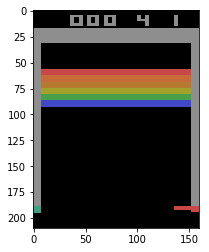

Reward: 0.0
Iters : 105


In [174]:
model = PPO1_Mod.load('mod_3_model_' + env_id)

env = make_atari(env_id)
env = wrap_deepmind(env)
env.reset()

obs = env.reset()

total_reward = 0
count = 0
frames = []
level_count = 5

taken = []
while True:
    actions = model.step(np.array([obs]))
    obs, reward, done, info = env.step(actions[0])
    taken.append(actions[0])
    total_reward += reward

    clear_output(wait=True)
    d = env.render(mode='rgb_array')
    plt.imshow(d)
    plt.show()
    frames.append(d)
        
    count += 1
    if count > 100:
        done = True
    if done:
        print("Reward:", total_reward)
        print("Iters :", count)
        level_count -= 1
        if level_count < 0:
            break

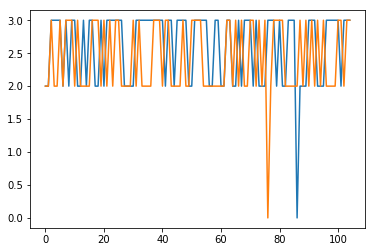

In [178]:
plt.plot(mod_taken)
#plt.plot(base_taken)
plt.plot(taken)
#plt.xlim((0,25))
#plt.ylim((2,3))